In [24]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC
import os 
useGPU = True
if useGPU == True: # 6 is for personal use 
    os.environ["CUDA_VISIBLE_DEVICES"] = "6"
elif useGPU == False: 
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
else: 
    raise ValueError("Incorrect value of useGPU variable")

In [46]:
seed = torch.Generator().manual_seed(2147483647)
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 20)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(2* train_x * (2 * math.pi)) + torch.randn(train_x.size(), generator=seed) * math.sqrt(0.04)

In [51]:
from gpytorch.priors import NormalPrior
from gpytorch.constraints import Positive, GreaterThan
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True, jitter_val = 1e-4)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
inducing_points = torch.linspace(0.0, 1.0, 500)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(inducing_points)

TypeError: __init__() takes 2 positional arguments but 4 were given

In [52]:
import os
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 100
warmup_steps = 2 if smoke_test else 100


from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(train_x, train_y)

Warmup:   2%|▏         | 4/200 [01:42, 36.46s/it, step size=4.48e-05, acc. prob=0.026]

KeyboardInterrupt: 

In [49]:
model.pyro_load_from_samples(mcmc_run.get_samples())
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_samples, 1, 1)
output = model(expanded_test_x)

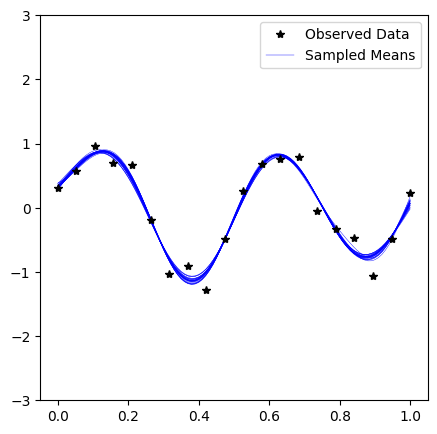

In [50]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])